# Computational Proteoform Identification Analysis

In [1]:
import os
import sys
import feather
import warnings
from multiprocessing import Pool

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 

sys.path.append('../')
from src import tests, utils, plots

warnings.filterwarnings('ignore')

# Initialize the timer
startTime = utils.getTime()

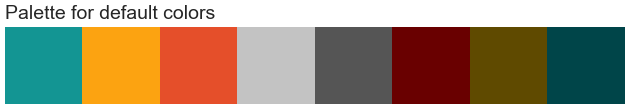

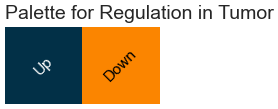

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]

status_colors = {
    "Tumor": "#023047",
    "Normal": "#fb8500",
}
regulation_colors = {
    'Up': "#023047",
    'Down': '#fb8500'
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

# plots.color_palette(
#     status_colors,
#     name="Status",
#     save=False
# )

plots.color_palette(
    regulation_colors,
    name="Regulation in Tumor",
    save=False
)

### Data Paths

In [3]:
notebook_name = "3_ProteoForge"
data_path = "./data/processed/"
output_path = f"./data/results/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

## Load the data

### Metadata

In [4]:
# Open the feather file
metadata = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_Metadata.feather")
utils.print_shape(metadata, "Metadata")
metadata.head()

Metadata data has 20 rows and 15 columns


,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
9,[67] 20240313_GB_NBL-macro-74_Slot1-58_1_399.h...,20240313,NBL-macro-74,Slot1-58,NBL-macro-74_Slot1-58,74.0000,9.0000,Normal,None,None,None,None,AG,None,True
13,[68] 20240313_GB_NBL-macro-75_Slot1-59_1_400.h...,20240313,NBL-macro-75,Slot1-59,NBL-macro-75_Slot1-59,75.0000,13.0000,Normal,None,None,None,None,AG,None,True
15,[69] 20240313_GB_NBL-macro-76_Slot1-60_1_401.h...,20240313,NBL-macro-76,Slot1-60,NBL-macro-76_Slot1-60,76.0000,14.0000,Normal,None,None,None,None,AG,None,True
36,[71] 20240313_GB_NBL-macro-78_Slot1-62_1_403.h...,20240313,NBL-macro-78,Slot1-62,NBL-macro-78_Slot1-62,78.0000,33.0000,Normal,None,None,None,None,AG,None,True
43,[152] 20240322_GB_NBL-macro-80_Slot1-71_1_506....,20240322,NBL-macro-80,Slot1-71,NBL-macro-80_Slot1-71,80.0000,38.0000,Normal,None,None,None,None,AG,None,True


### Peptide Info

In [5]:
# Peptide Information
info_subset = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_PeptideLevel_InfoData.feather")
utils.print_shape(info_subset, "Peptide Info")
info_subset.head()

Peptide Info data has 117,290 rows and 11 columns


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID
0,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,1,10,181,0,23.7569,False,1
1,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,10,18,181,0,23.7569,False,2
2,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,27,41,181,0,23.7569,False,3
3,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,90,181,0,23.7569,False,4
4,A0A024RBG1,LLGIFEQNQDRK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,91,181,1,23.7569,False,5


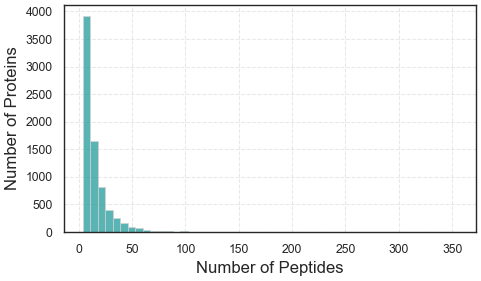

In [6]:
# Histogram with Peptide Number per Protein
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
cnts = info_subset["Protein"].value_counts()
sns.histplot(
    cnts, bins=50, color=def_colors[0], ax=ax, edgecolor="lightgrey", alpha=0.7, linewidth=.5,
)
ax.set_title("" , fontsize=14, loc="left", pad=10)
ax.set_xlabel("Number of Peptides", fontsize=12)
ax.set_ylabel("Number of Proteins", fontsize=12)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="PeptideNumberPerProtein",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### UniProt Annotations Data

In [7]:
# UniProt Annotation Data
uniprot_annotation = feather.read_dataframe(f"{data_path}Uniprot_Annotation.feather")
utils.print_shape(uniprot_annotation, "Uniprot Annotation")
uniprot_annotation.head()

Uniprot Annotation data has 370,812 rows and 6 columns


,protein_id,feature,isoform_id,start,end,note
941,A0AV96,CHAIN,,1.0000,593.0000,RNA-binding protein 47
942,A0AV96,DOMAIN,,71.0000,149.0000,RRM 1
943,A0AV96,DOMAIN,,151.0000,233.0000,RRM 2
944,A0AV96,DOMAIN,,246.0000,318.0000,RRM 3
945,A0AV96,REGION,,1.0000,25.0000,Disordered


### Test Data

In [8]:
# Test data containing all quantiative and other info for ProteoForge
test_data = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_PeptideLevel_TestData.feather")
utils.print_shape(test_data, "Test (long-format)")
test_data.head()

Test (long-format) data has 2,345,800 rows and 13 columns


,Protein,Peptide,PeptideID,Sample,Condition,Intensity,log10(Intensity),adjIntensity,isReal,isCompMiss,imputeW,TechVarW,Weight
0,A0A024RBG1,MKFKPNQTR,1,NBL-macro-74_Slot1-58,Normal,212.0579,2.3265,0.0685,False,False,0.0000,0.9965,0.0943
1,A0A024RBG1,TYDREGFK,2,NBL-macro-74_Slot1-58,Normal,209.3483,2.3209,-0.1467,False,False,0.0000,0.9879,0.0935
2,A0A024RBG1,SEQEDEVLLVSSSR,3,NBL-macro-74_Slot1-58,Normal,3387.1516,3.5298,0.4020,False,True,0.7500,0.9453,0.7682
3,A0A024RBG1,LLGIFEQNQDR,4,NBL-macro-74_Slot1-58,Normal,214.4361,2.3313,-0.0740,True,False,1.0000,0.9572,0.9957
4,A0A024RBG1,LLGIFEQNQDRK,5,NBL-macro-74_Slot1-58,Normal,248.7292,2.3957,0.1671,False,True,0.7500,0.9808,0.7717


# Applying ProteoForge

## Extract Clusters from Intensity

Extracting Clusters for ProteoForge's Proteoform Grouping


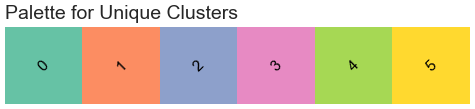

The clusters are extracted in 00h:01m:22s

Cluster ID Counts
   0 -> 1087160
   1 -> 816780
   2 -> 362700
   3 -> 70560
   4 -> 8180
   5 -> 420

Test (long-format) data has 2,345,800 rows and 14 columns


,Protein,Peptide,PeptideID,Sample,Condition,Intensity,log10(Intensity),adjIntensity,isReal,isCompMiss,imputeW,TechVarW,Weight,cluster_id
0,A0A024RBG1,MKFKPNQTR,1,NBL-macro-74_Slot1-58,Normal,212.0579,2.3265,0.0685,False,False,0.0000,0.9965,0.0943,1
1,A0A024RBG1,TYDREGFK,2,NBL-macro-74_Slot1-58,Normal,209.3483,2.3209,-0.1467,False,False,0.0000,0.9879,0.0935,0
2,A0A024RBG1,SEQEDEVLLVSSSR,3,NBL-macro-74_Slot1-58,Normal,3387.1516,3.5298,0.4020,False,True,0.7500,0.9453,0.7682,2
3,A0A024RBG1,LLGIFEQNQDR,4,NBL-macro-74_Slot1-58,Normal,214.4361,2.3313,-0.0740,True,False,1.0000,0.9572,0.9957,0
4,A0A024RBG1,LLGIFEQNQDRK,5,NBL-macro-74_Slot1-58,Normal,248.7292,2.3957,0.1671,False,True,0.7500,0.9808,0.7717,0


In [9]:
# Commented out due to long runtime (if results_df not available run this and next)

sT = utils.getTime()
print("Extracting Clusters for ProteoForge's Proteoform Grouping")
### Add cluster_ids

# Calculate the clustering 
def build_proteoform_groups_mp(protein):
    return utils.build_proteoform_groups(
        cur_protein=protein,
        data = test_data,
        sample_col="Sample",
        peptide_col="Peptide",
        protein_col="Protein",
        quant_col='adjIntensity',
        minSizePct=0.55, 
        absoluteMaxSize=3,
        corrMethod="kendall",
        distanceMethod="euclidean",
        linkageMethod="complete",
    )
from multiprocessing import Pool
with Pool(28) as p:
    clusters = p.map(build_proteoform_groups_mp, test_data['Protein'].unique())
clusters = pd.concat(clusters, axis=0, ignore_index=True)

# Create colormap for Clusters
uniqClusters = clusters["cluster_id"].sort_values().unique()
cluster_palette = sns.color_palette("Set2", len(uniqClusters)).as_hex()
cluster_palette = dict(zip(uniqClusters, cluster_palette))

plots.color_palette(
    cluster_palette,
    name="Unique Clusters",
    save=False
)

# Add the cluster palette to the test data
test_data = test_data.merge(
    clusters,
    on=["Protein", "Peptide"],
    how="left"
)
print(f"The clusters are extracted in {utils.prettyTimer(utils.getTime() - sT)}")
print()
utils.print_series(
    test_data["cluster_id"].value_counts(),
    header="Cluster ID Counts",
    tab=2
)
print()
utils.print_shape(test_data, "Test (long-format)")
test_data.head()

## Linear Model for Interaction Terms

The second part is to find the significantly discordant peptides from each protein using a linear model. ProteoForge uses various linear models with weights to find the discordant peptides. The default implements the weighted least squares model, however quantile, generalized, and robust regression based models with weights are also available. The weights are assigned based on the technical reproducibility with (15% importance) and the imputation type (85% importance). The two main imputation, one is for biological absence which has .75 weight, and the other is random missingness which has 10**-5 weight. The real values have weight of 1 for imputation type. 

### Running the Model

In [10]:
# Commented out due to long runtime (if results_df not available run this and previous)

sT = utils.getTime()
print("Extracting Discordant Peptides for ProteoForge")
# Run the model
results_df = tests.run_model(
    test_data,
    cond_col="Condition",
    intensity_col="adjIntensity",
    protein_col="Protein",
    peptide_col="Peptide",
    correction_type="fdr",
    model_type='wls',
    weight_col="Weight"
)
print(f"The discordant peptides are extracted in {utils.prettyTimer(utils.getTime() - sT)}")
print()
utils.print_shape(results_df, "Results data (long-format)")
# Save data to a feather file
results_df.to_feather(f"{output_path}results_df.feather")

Extracting Discordant Peptides for ProteoForge


100%|██████████| 7491/7491 [20:13<00:00,  6.17it/s]  


The discordant peptides are extracted in 00h:20m:17s

Results data (long-format) data has 2,345,800 rows and 16 columns


### Expand Results and Create Collapsed Expanded Info Data

In [21]:
pThr = 10**-6

# Load the results from the feather file
results_df = feather.read_dataframe(f"{output_path}results_df.feather")

# Get tumor regulation (Up in tumor, down in tumor)
tmp = results_df.reset_index().groupby([
    "Protein", "Peptide", "Condition"
])["log10(Intensity)"].mean().unstack()
tmp['TumorRegulation'] = (tmp['Tumor'] - tmp['Normal']).map(lambda x: 'Up' if x > 0 else 'Down')
results_df = results_df.merge(
    tmp['TumorRegulation'],
    on=["Protein", "Peptide"],
    how="left"
)
# Add the significance
results_df['isSignificant'] = results_df['adj_pval'] <= pThr    

# Get the data compressed
tmp = results_df[[
    "Protein", "Peptide", "PeptideID", 
    "TumorRegulation", "cluster_id", 
    "pval", "adj_pval", 'isSignificant'
]].drop_duplicates()
utils.print_shape(tmp, "Analyte Results")

# Count the number of significant peptides
print(f"Significant hits (raw < {pThr}):", (tmp["pval"] <= pThr).astype(int).sum())
print(f"Significant hits (FDR < {pThr}):", (tmp["adj_pval"] <= pThr).astype(int).sum())

print()
print("The significant interaction analysis with ANOVA done on the data.")
print(
    "Total peptides:",
    tmp["Peptide"].nunique(),
    "\nTotal proteins:",
    tmp["Protein"].nunique()
)
# print("The results are saved in the file: results_df.feather")
print()
print(
    "Significant peptides:",
    tmp["isSignificant"].sum(),
    "\nProteins with at least one significant peptide:",
    tmp.loc[tmp["isSignificant"], "Protein"].nunique(),
)
print()

tmp.head()

Analyte Results data has 117,290 rows and 8 columns
Significant hits (raw < 1e-06): 12537
Significant hits (FDR < 1e-06): 10117

The significant interaction analysis with ANOVA done on the data.
Total peptides: 117290 
Total proteins: 7491

Significant peptides: 10117 
Proteins with at least one significant peptide: 5907



,Protein,Peptide,PeptideID,TumorRegulation,cluster_id,pval,adj_pval,isSignificant
0,A0A024RBG1,MKFKPNQTR,1,Up,1,0.0034,0.0132,False
1,A0A024RBG1,TYDREGFK,2,Down,0,0.0000,0.0000,True
2,A0A024RBG1,SEQEDEVLLVSSSR,3,Down,2,0.0124,0.0400,False
3,A0A024RBG1,LLGIFEQNQDR,4,Down,0,0.1599,0.3053,False
4,A0A024RBG1,LLGIFEQNQDRK,5,Down,0,0.4427,0.6194,False


In [23]:
s1 = (5854 / 6439) * 100
s2 = (5907 / 7491) * 100
print(f"Significant proteins (prev): {s1:.2f}%")
print(f"Significant proteins (cur): {s2:.2f}%")

Significant proteins (prev): 90.91%
Significant proteins (cur): 78.85%


In [37]:
# Add the results_df is
expanded_info_data = info_subset.merge(
    tmp.drop(columns=["PeptideID"]), 
    on=["Protein", "Peptide"], 
    how="left"
).dropna()
expanded_info_data["isSignificant"] = expanded_info_data["isSignificant"].fillna(False)
# Create a specific sorting with the Protein, startpos, and endpos
expanded_info_data = expanded_info_data.sort_values(["Protein", "startpos", "endpos"]).reset_index(drop=True)
expanded_info_data = expanded_info_data

expanded_info_data.rename(columns={"adj_pval": "adj.pvalue"}, inplace=True)
utils.print_shape(expanded_info_data, "Expanded Info")
expanded_info_data.head()

Expanded Info data has 117,215 rows and 16 columns


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,cluster_id,pval,adj.pvalue,isSignificant
0,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,1,10,181,0,23.7569,False,1,Up,1,0.0034,0.0132,False
1,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,10,18,181,0,23.7569,False,2,Down,0,0.0000,0.0000,True
2,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,27,41,181,0,23.7569,False,3,Down,2,0.0124,0.0400,False
3,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,90,181,0,23.7569,False,4,Down,0,0.1599,0.3053,False
4,A0A024RBG1,LLGIFEQNQDRK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,91,181,1,23.7569,False,5,Down,0,0.4427,0.6194,False


### Protein Info Data

,Protein,Cov%,seqLength,Peptide,isSignificant,Significant%
0,Q8N960,10.8519,986,4,2,50.0000
1,O43156,8.5399,1089,4,2,50.0000
2,P30825,14.1494,629,4,2,50.0000
3,Q9NYL2,27.8750,800,4,2,50.0000
4,Q9Y5Y2,31.3653,271,4,2,50.0000


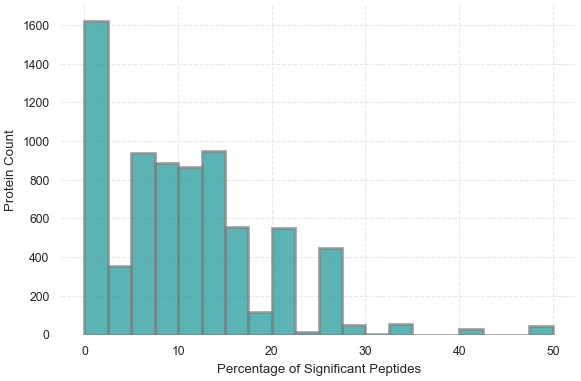

In [38]:
# Create Protein Info 
protein_info = expanded_info_data.groupby("Protein").agg({
    "Cov%": "max",
    "seqLength": "min",
    "Peptide": "count",
    "isSignificant": "sum"
}).reset_index()
protein_info["Significant%"] = protein_info["isSignificant"] / protein_info["Peptide"] * 100
protein_info = protein_info.sort_values("Significant%", ascending=False).reset_index(drop=True)

## percentage of significant peptides per protein
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
protein_info["Significant%"].hist(bins=20, color=def_colors[0], edgecolor="grey", alpha=0.7, linewidth=2, ax=ax)
ax.set_title("" , fontsize=12, loc="left", pad=10)
ax.set_xlabel("Percentage of Significant Peptides")
ax.set_ylabel("Protein Count")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
sns.despine(left=True, bottom=True)
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="SummaryOfProteins_SignificantPeptides",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)
protein_info.head()

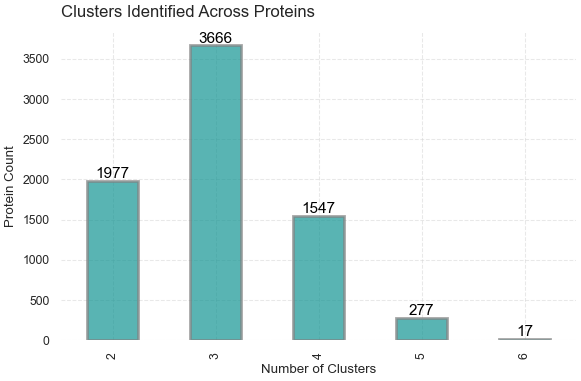

In [39]:
## Number of Unique Clusters per Protein
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
expanded_info_data.groupby('Protein')['cluster_id'].nunique().value_counts().sort_index().plot(
    kind="bar", color=def_colors[0], edgecolor="grey", linewidth=2,
    alpha=0.7, ax=ax
)
# Add the count annotations to the bars
for i in ax.patches:
    ax.text(
        i.get_x() + i.get_width() / 2,
        i.get_height() + 0.5,
        f"{int(i.get_height())}",
        ha="center",
        va="bottom",
        color="black",
        fontsize=11,
    )
ax.set_title("Clusters Identified Across Proteins ", fontsize=12, loc="left", pad=10)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Protein Count")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
sns.despine(left=True, bottom=True)
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="ClustersPerProtein",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Mapping the Significant Clusters to Proteoform Groups

In [40]:
# Initialize the ProteoformGroup column
expanded_info_data['ProteoformGroup'] = -1
for (protein, group), data in expanded_info_data.groupby(["Protein", "cluster_id"]):
    if data['isSignificant'].any():
        expanded_info_data.loc[data.index, 'ProteoformGroup'] = group

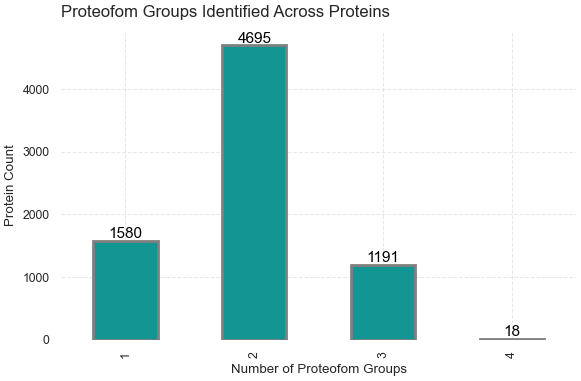

In [41]:
## Number of Unique Proteoform Groups per Protein
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
expanded_info_data.groupby([
    "Protein"
])["ProteoformGroup"].nunique().value_counts().sort_index().plot(
    kind="bar", color=def_colors[0], edgecolor="grey", linewidth=2, ax=ax
)

# Add the count annotations to the bars
for i in ax.patches:
    ax.text(
        i.get_x() + i.get_width() / 2,
        i.get_height() + 0.5,
        f"{int(i.get_height())}",
        ha="center",
        va="bottom",
        color="black",
        fontsize=11,
    )

ax.set_title("Proteofom Groups Identified Across Proteins", fontsize=12, loc="left", pad=10)
ax.set_xlabel("Number of Proteofom Groups")
ax.set_ylabel("Protein Count")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
sns.despine(left=True, bottom=True)
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="ProteoformGroupsPerProtein",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Save The Data to Results

In [42]:
feather.write_dataframe(expanded_info_data, f"{output_path}expanded_info_data.feather")

# Conclusion

WIP

In [43]:
print("Notebook Execution Time:", utils.prettyTimer(utils.getTime() - startTime))

Notebook Execution Time: 00h:30m:08s
